# Semantic Segmentation Using U-Net
### Artificial Intelligence Course | Instructed by DR. MohammadHossein Rohban
<font color='cyan'> Responsible TAs: Amirhossein Razlighi, Reza Vahidimajd </font>

<font color='yellow'> Please ask your questions via [Quera](www.quera.com) </font>

<b> Team Members: </b>
</br>
Mohammad Aref Zarezadeh 401106017
</br>
Mohammad Hossein Eslami 401105537
</br>
Pouria Ghafouri 401106277

In this excercise, you will design and train a CNN-based network called U-Net. This type of networks are used for semantic segmentation. This task is, as it's called, segmenting the image, semantically to different parts. You can consider this as a classification, done on each pixel of the image! Below, you can see an example of the task:


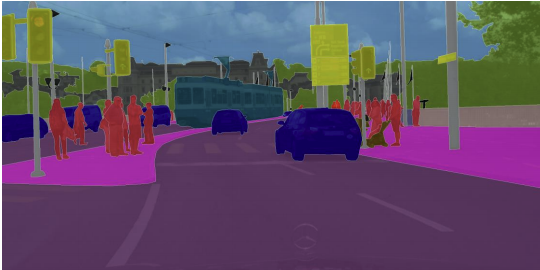 <br>
Example of a segmented image <br>


We will use a dataset which is used for "Self-Driving Car" Purposes. As you may know, understanding each pixel (in the view point of car) is an important task for self-driving cars. Let's proceed with this task to the end of this excercise!

## Downloading Dataset

In [1]:
%pip install --upgrade --no-cache-dir gdown

Note: you may need to restart the kernel to use updated packages.


In [2]:
!kaggle datasets download -d mojtabanafez/self-driving-car-dataset-ai-course

'kaggle' is not recognized as an internal or external command,
operable program or batch file.


In [3]:
!unzip self-driving-car-dataset-ai-course.zip

'unzip' is not recognized as an internal or external command,
operable program or batch file.


In [4]:
%pip install --upgrade torch torchvision torchsummary

<a name='1'></a>
## 1 - Packages

Run the cell below to import all the libraries you'll need:

In [5]:
import numpy as np
import torch
import torch.nn as nn
from torchsummary import summary
from torchvision import transforms, io
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
import pandas as pd
import imageio
import matplotlib.pyplot as plt
from torch.optim import Adam
import time
%matplotlib inline

### Set torch device to appropriate type for GPU training

In [6]:
device = torch.device(
    "mps"
    if torch.backends.mps.is_available()
    else (
        "cuda"
        if torch.cuda.is_available()
        else "mps" if torch.backends.mps.is_available() else "cpu"
    )
)
device

device(type='cuda')

<a name='2'></a>
## 2 - Load the Data

In [7]:
path = "" # Path to the root folder
image_path = os.path.join(path, "Files/data/CameraRGB/")
mask_path = os.path.join(path, "Files/data/CameraMask/")
image_list = sorted(os.listdir(image_path))
mask_list = sorted(os.listdir(mask_path))
image_list = [image_path+i for i in image_list]
mask_list = [mask_path+i for i in mask_list]

### Check out the some of the unmasked and masked images from the dataset:

After you are done exploring, revert back to `N=5`

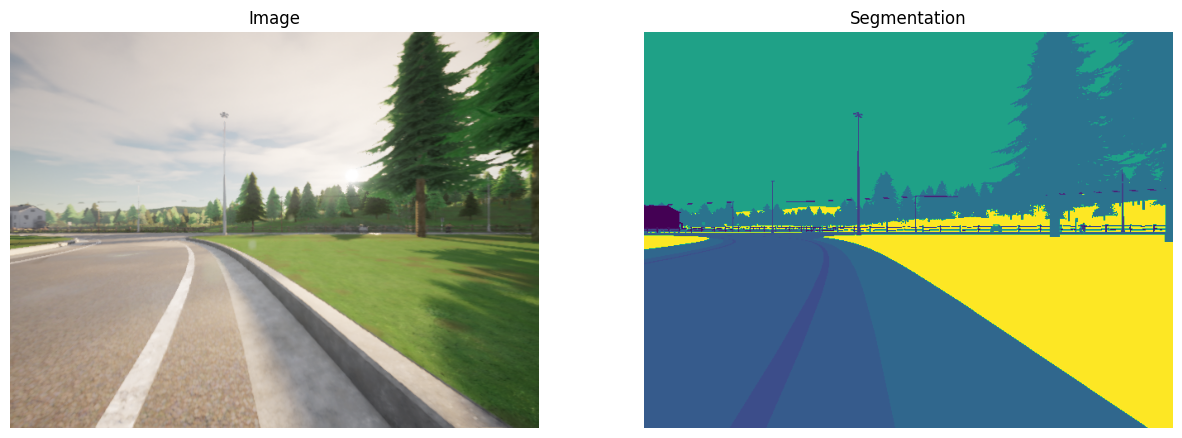

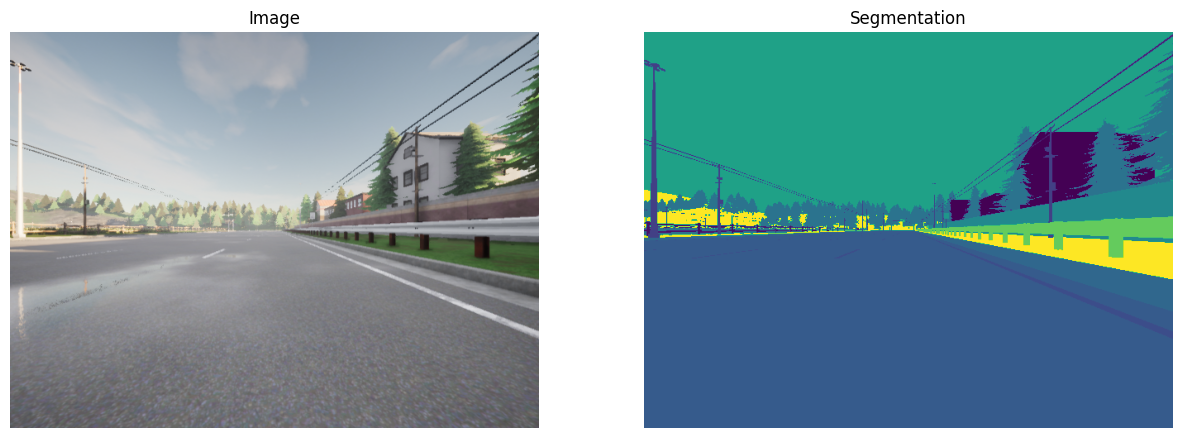

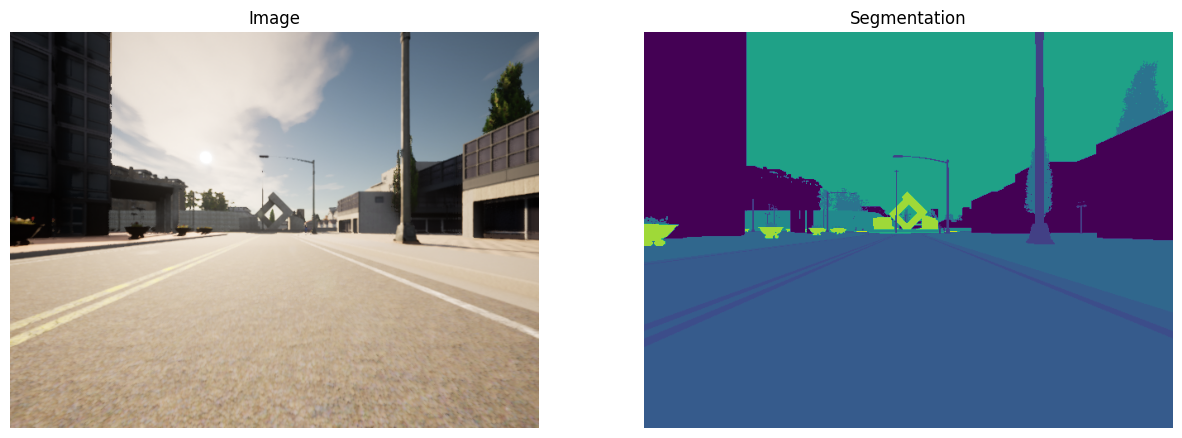

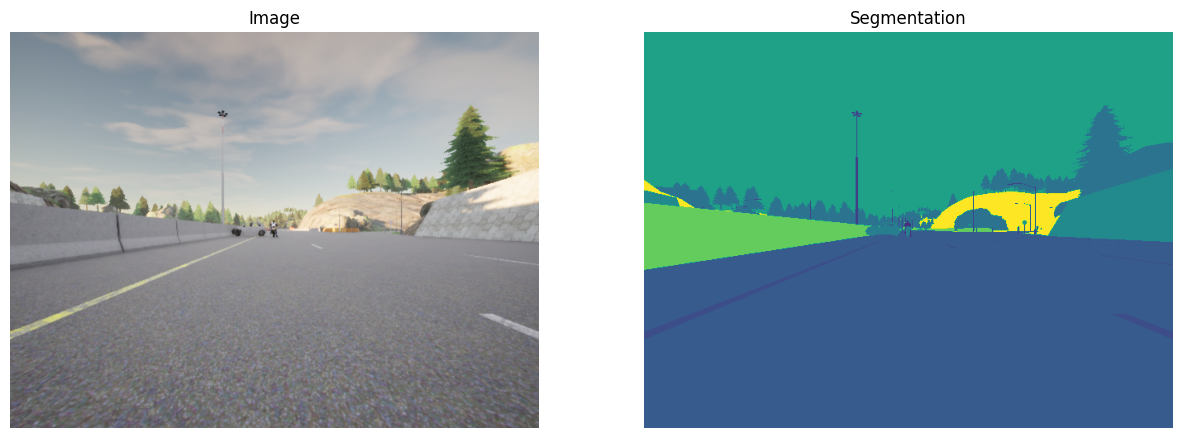

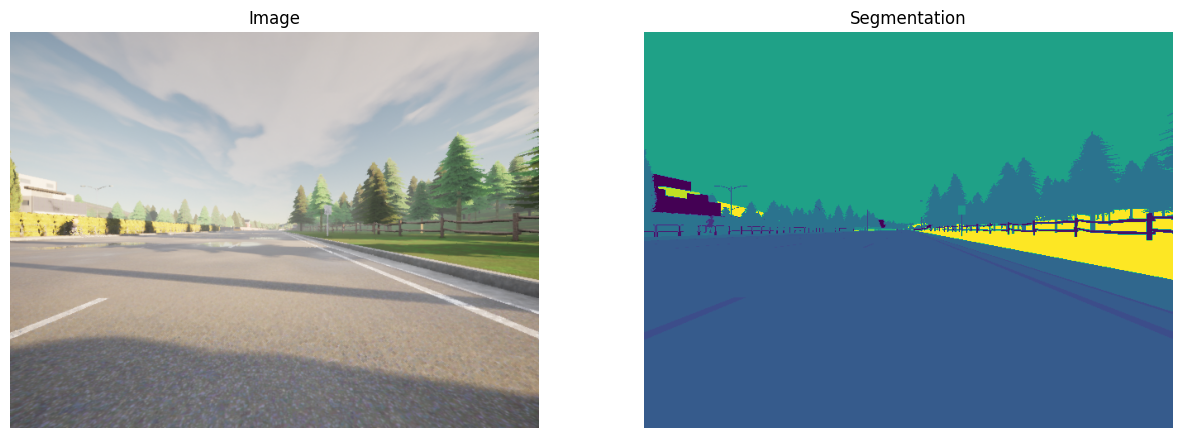

In [8]:
N = 5
# TODO
img = ...
mask = ...

# Plot the images and masks alongside each other
for i in range(N):
  random_index = np.random.randint(0, len(image_list))
  fig, ax = plt.subplots(1,2, figsize=(15, 15))
  img = Image.open(image_list[random_index])
  img = np.array(img)
  ax[0].imshow(img)
  ax[0].set_title("Image")
  ax[0].axis('off')
  gray_img = Image.open(mask_list[random_index])
  gray_img = np.array(gray_img)
  gray_img = gray_img[:, :, 0]


  ax[1].imshow(gray_img)
  ax[1].set_title("Segmentation")
  ax[1].axis('off')

<a name='2-2'></a>
### 2.2 - Preprocess Your Data



In [9]:
class Segmentation_Dataset(Dataset):
    def __init__(self, ImagesDirectory, MasksDirectory):
        #TODO: Do anything necessary to initialize the object
        ...
        # TODO: Define the mask transforms
        # Your transform should contain: Resizing to 192x256 (and any more things you want to add!)
        self.mask_transforms = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Resize((192, 256)),
                lambda mask: mask[0],
                lambda mask: (255 * mask).type(torch.LongTensor)
            ]
        )

        # TODO: Define the image transforms
        # Your transform should contain: Transforming to PIL image format, resizing to 192x256,
        # converting to tensor and selecting only the first 3 channels (and any more things you want to add!)
        self.image_transforms = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Resize((192, 256))

            ]
        )
        tmp_image_files = sorted(os.listdir(ImagesDirectory))
        tmp_mask_files = sorted(os.listdir(MasksDirectory))
        self.image_files = []
        self.mask_files = []

        for item in tmp_image_files:
          self.image_files.append(os.path.join(ImagesDirectory, item))

        for item in tmp_mask_files:
          self.mask_files.append(os.path.join(MasksDirectory, item))



    def __len__(self):
        # TODO
        return len(self.image_files)

    def __getitem__(self, index):
        # TODO
        img, mask = self.image_files[index], self.mask_files[index]
        if isinstance(index, slice):
          tmp_img = []
          tmp_mask = []
          for item in img:
            tmp_img.append(self.image_transforms(self.read_image(item)))
          for item in mask:
             tmp_mask.append(self.mask_transforms(self.read_imag(item)))
          img = tmp_img
          mask = tmp_mask
        else:
          img = self.image_transforms(self.read_image(img))
          mask = self.mask_transforms(self.read_image(mask))

        return img, mask


    def read_image(self, path):
        img = Image.open(path)
        # Converting image to RGB format
        return img.convert('RGB')

<a name='2-3'></a>
### 2.3 - Hyper-parameters and Optimizer

In [10]:
# TODO
EPOCHS = 30
BATCH_SIZE = 8
LR = 0.000175
B1 = 0.9
B2 = 0.999
max_grad_norm = 1.0

<a name='3'></a>
## 3 - U-Net

U-Net, named for its U-shape, was originally created in 2015 for tumor detection, but in the years since has become a very popular choice for other semantic segmentation tasks.

U-Net builds on a previous architecture called the Fully Convolutional Network, or FCN, which replaces the dense layers found in a typical CNN with a transposed convolution layer that upsamples the feature map back to the size of the original input image, while preserving the spatial information. This is necessary because the dense layers destroy spatial information (the "where" of the image), which is an essential part of image segmentation tasks. An added bonus of using transpose convolutions is that the input size no longer needs to be fixed, as it does when dense layers are used.

You will see the transpose convolution referred to by several names, including "deconvolution" and "upconvolution", but these are all the same thing. You will also see the model's architecture in the following cells.

<a name='3-1'></a>
### 3.1 - Model Details

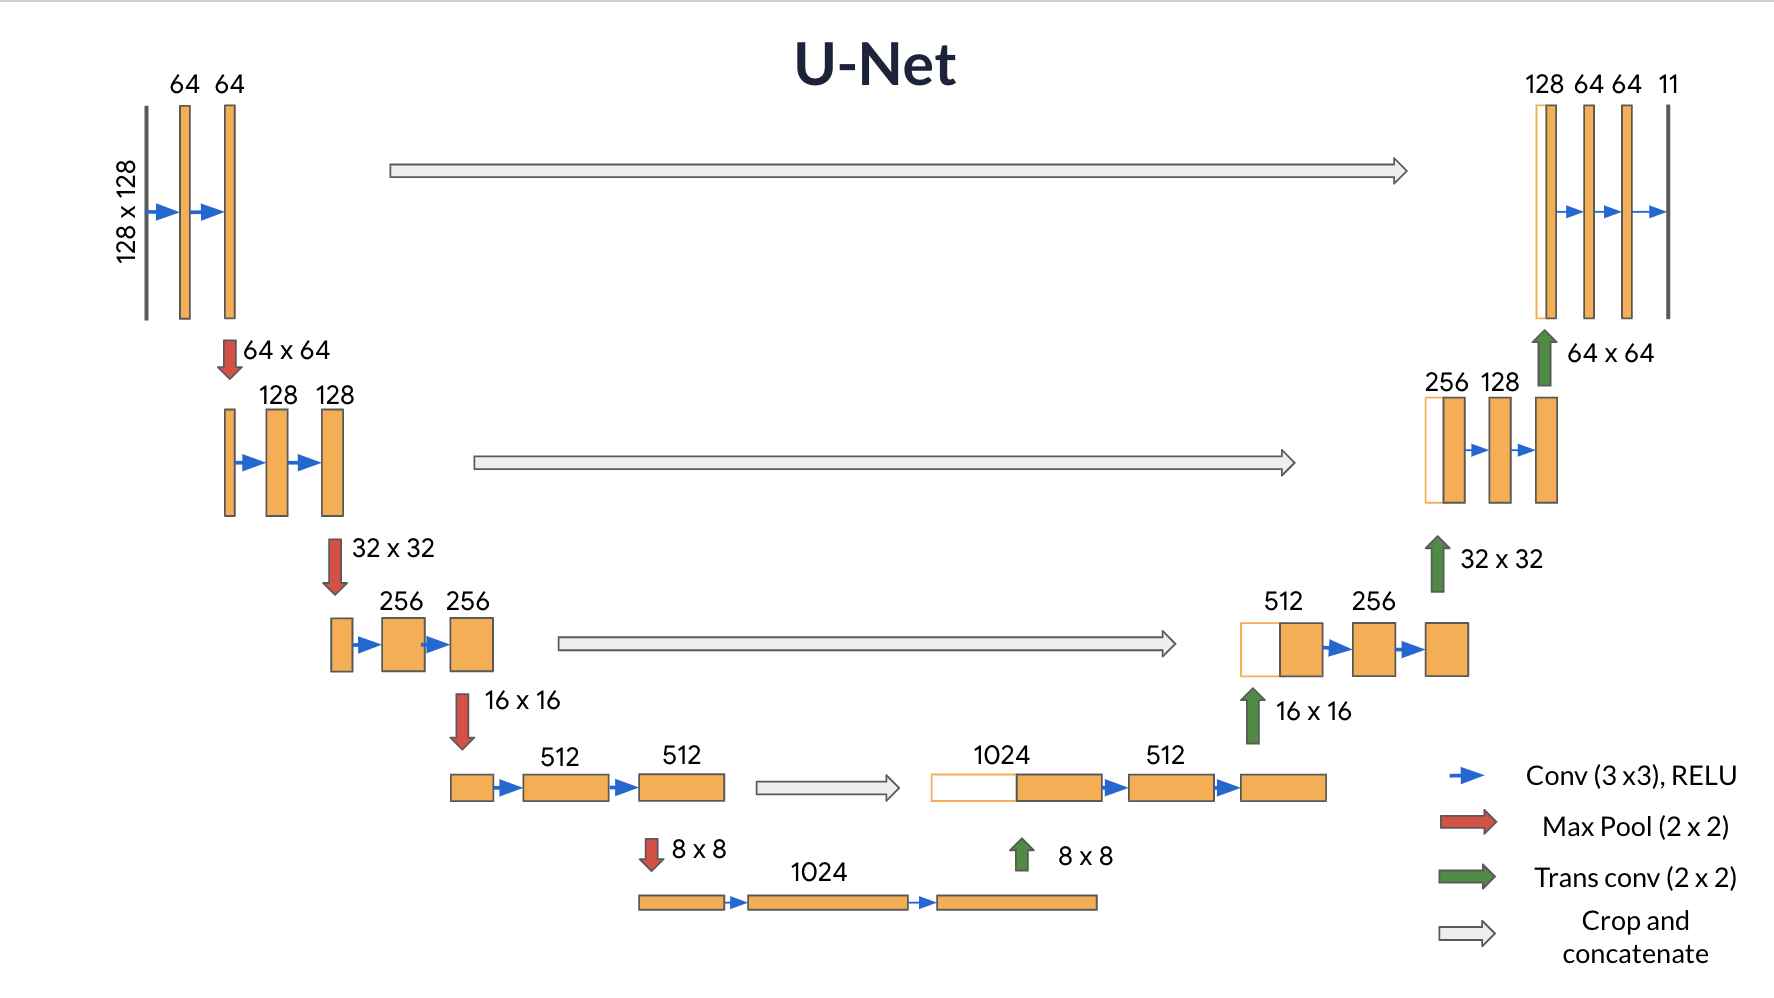<br>
U-Net Architecture<br>

**Contracting path** (Encoder containing downsampling steps):

Images are first fed through several convolutional layers which reduce height and width, while growing the number of channels.

The contracting path follows a regular CNN architecture, with convolutional layers, their activations, and pooling layers to downsample the image and extract its features. In detail, it consists of the repeated application of two 3 x 3 valid padding convolutions, each followed by a rectified linear unit (ReLU) and a 2 x 2 max pooling operation with stride 2 for downsampling. At each downsampling step, the number of feature channels is doubled.

**Crop function**: This step crops the image from the contracting path and concatenates it to the current image on the expanding path to create a skip connection.

**Expanding path** (Decoder containing upsampling steps):

The expanding path performs the opposite operation of the contracting path, growing the image back to its original size, while shrinking the channels gradually.

In detail, each step in the expanding path upsamples the feature map, followed by a 2 x 2 convolution (the transposed convolution). This transposed convolution halves the number of feature channels, while growing the height and width of the image.

Next is a concatenation with the correspondingly cropped feature map from the contracting path, and two 3 x 3 convolutions, each followed by a ReLU. You need to perform cropping to handle the loss of border pixels in every convolution.

**Final Feature Mapping Block**: In the final layer, a 1x1 convolution is used to map each 64-component feature vector to the desired number of classes. The channel dimensions from the previous layer correspond to the number of filters used, so when you use 1x1 convolutions, you can transform that dimension by choosing an appropriate number of 1x1 filters. When this idea is applied to the last layer, you can reduce the channel dimensions to have one layer per class.

The U-Net network has 23 convolutional layers in total.

**Important Note:**
The figures shown in the assignment for the U-Net architecture depict the layer dimensions and filter sizes as per the original paper on U-Net with smaller images. However, due to computational constraints for this assignment, you will code only half of those filters. The purpose of showing you the original dimensions is to give you the flavour of the original U-Net architecture. The important takeaway is that you multiply by 2 the number of filters used in the previous step. The notebook includes all of the necessary instructions and hints to help you code the U-Net architecture needed for this assignment.

<a name='3-2'></a>
### 3.2 - Encoder (Downsampling Block)

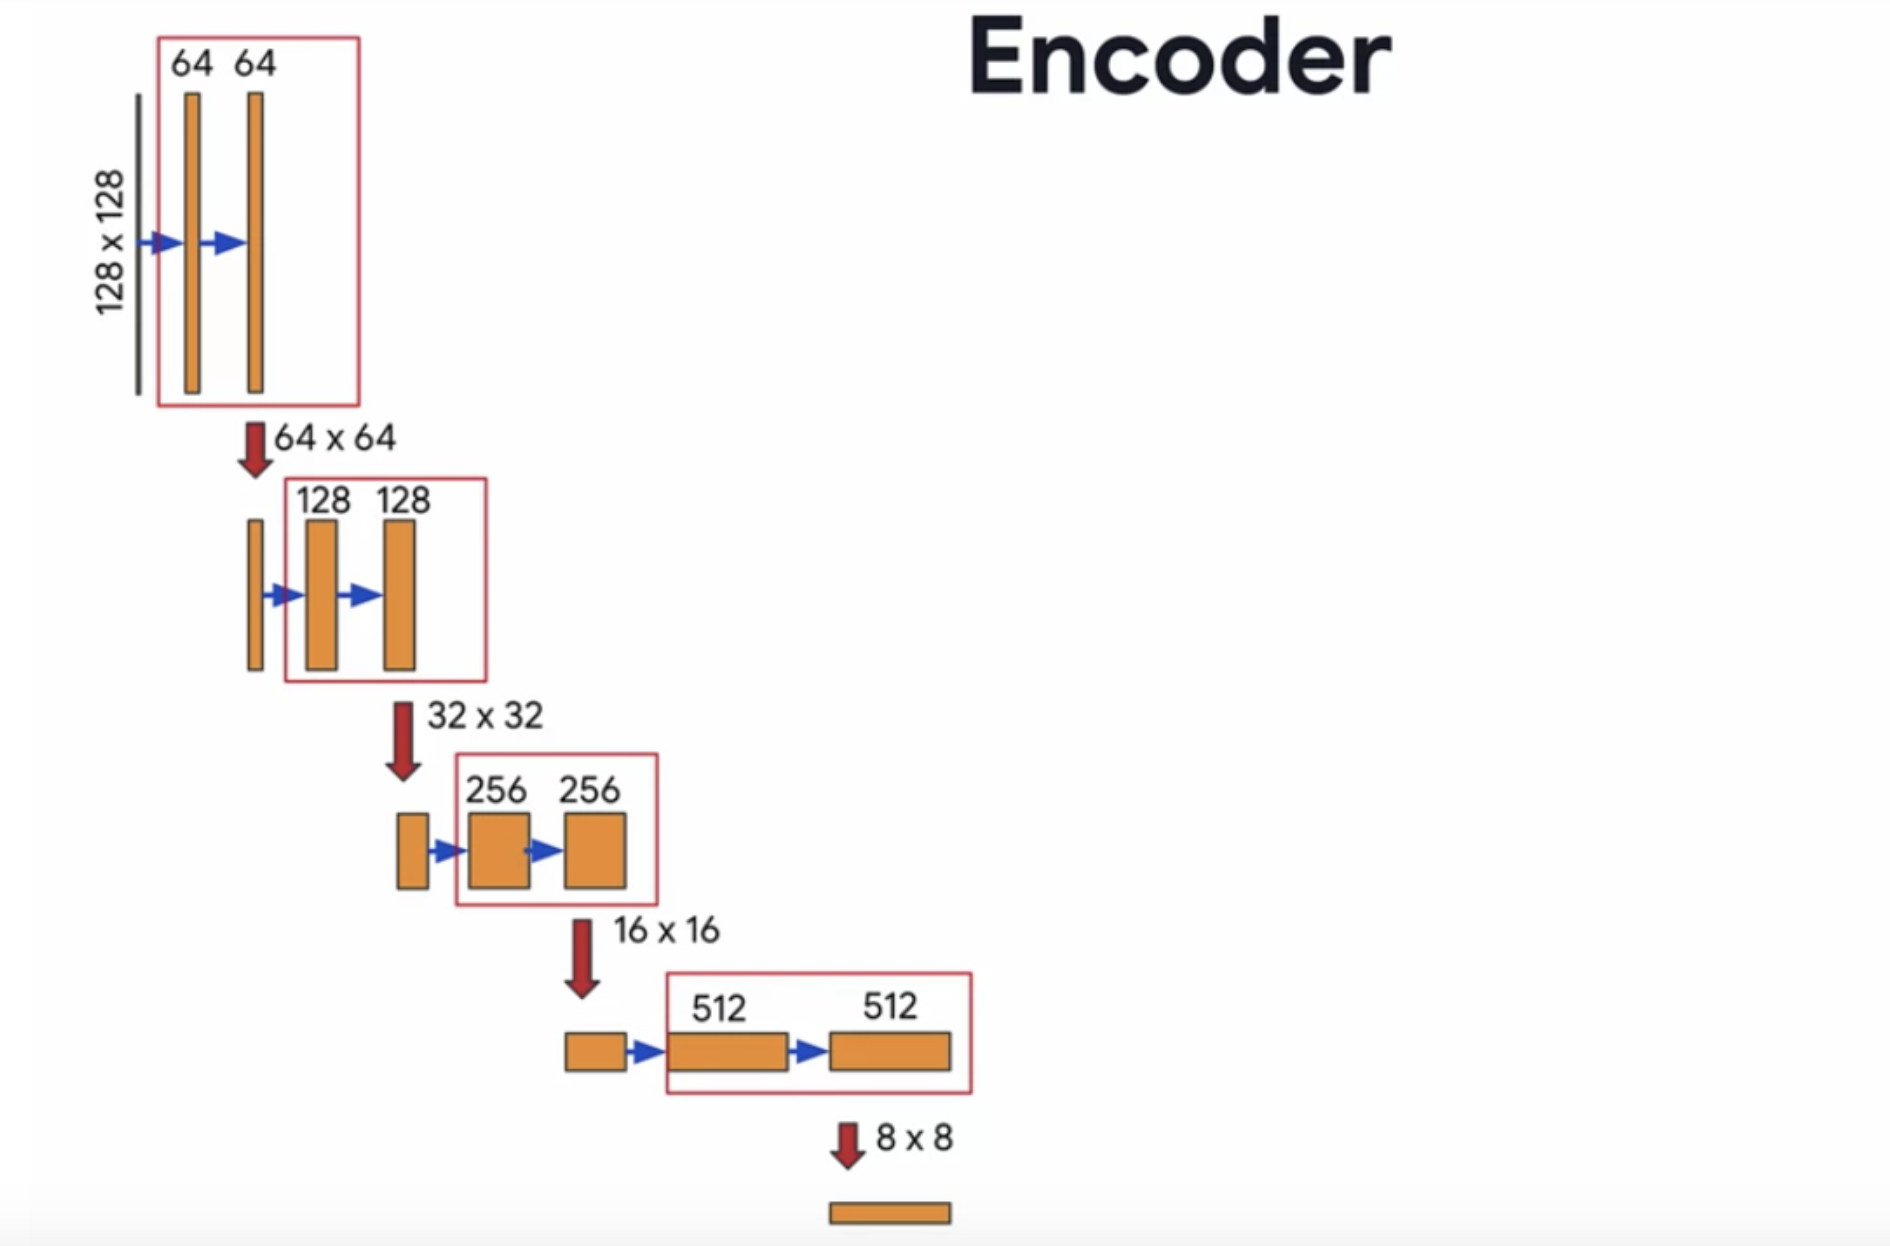<br>
The U-Net Encoder up close <br>

The encoder is a stack of various conv_blocks:

Each `conv_block()` is composed of 2 **Conv2D** layers  with ReLU activations. We will apply **Dropout**, and **MaxPooling2D** to some conv_blocks, as you will verify in the following sections, specifically to the last two blocks of the downsampling.

The function will  return two tensors:
- `next_layer`: That will go into the next block.
- `skip_connection`: That will go into the corresponding decoding block.

**Note**: If `max_pooling=True`, the `next_layer` will be the output of the MaxPooling2D layer, but the `skip_connection` will be the output of the previously applied layer(Conv2D or Dropout, depending on the case). Else, both results will be identical.  

In [11]:
class conv_block(nn.Module):
    def __init__(self, in_ch, n_filters=32, dropout_prob=0, max_pooling=True):
        """
        Convolutional downsampling block

        Arguments:
            in_ch -- Number of channels of input tensor
            n_filters -- Number of filters for the convolutional layers
            dropout_prob -- Dropout probability
            max_pooling -- Use MaxPooling2D to reduce the spatial dimensions of the output volume
        """
        super().__init__()
        ######################################################
        ###################### TO DO #########################
        ######################################################

        self.in_ch = in_ch
        self.n_filters = n_filters
        self.dropout_prob = dropout_prob
        self.max_pooling = max_pooling
        
        self.conv = nn.Sequential(
            nn.Conv2d(self.in_ch, self.n_filters, kernel_size=3, padding=1, bias=True),
            nn.BatchNorm2d(self.n_filters),
            nn.ReLU(inplace=True),
            nn.Conv2d(self.n_filters, self.n_filters, kernel_size=3, padding=1, bias=True),
            nn.BatchNorm2d(self.n_filters),
            nn.ReLU(inplace=True),
            nn.Dropout(p=self.dropout_prob)
        )
        
        if self.max_pooling:
            self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        else:
            self.pool = nn.Identity()
            
        ######################################################
        ######################################################
        ######################################################

    def forward(self, x):
        """
        Convolutional downsampling forward

        Arguments:
            x -- Input data/batch
        Returns:
            next_layer, skip_connection --  Next layer and skip connection outputs
        """
        ######################################################
        ###################### TO DO #########################
        ######################################################
        skip_connection = self.conv(x)
        next_layer = self.pool(skip_connection)
        return next_layer, skip_connection
        ######################################################
        ######################################################
        ######################################################


<a name='3-3'></a>
### 3.3 - Decoder (Upsampling Block)

The decoder, or upsampling block, upsamples the features back to the original image size. At each upsampling level, you'll take the output of the corresponding encoder block and concatenate it before feeding to the next decoder block.

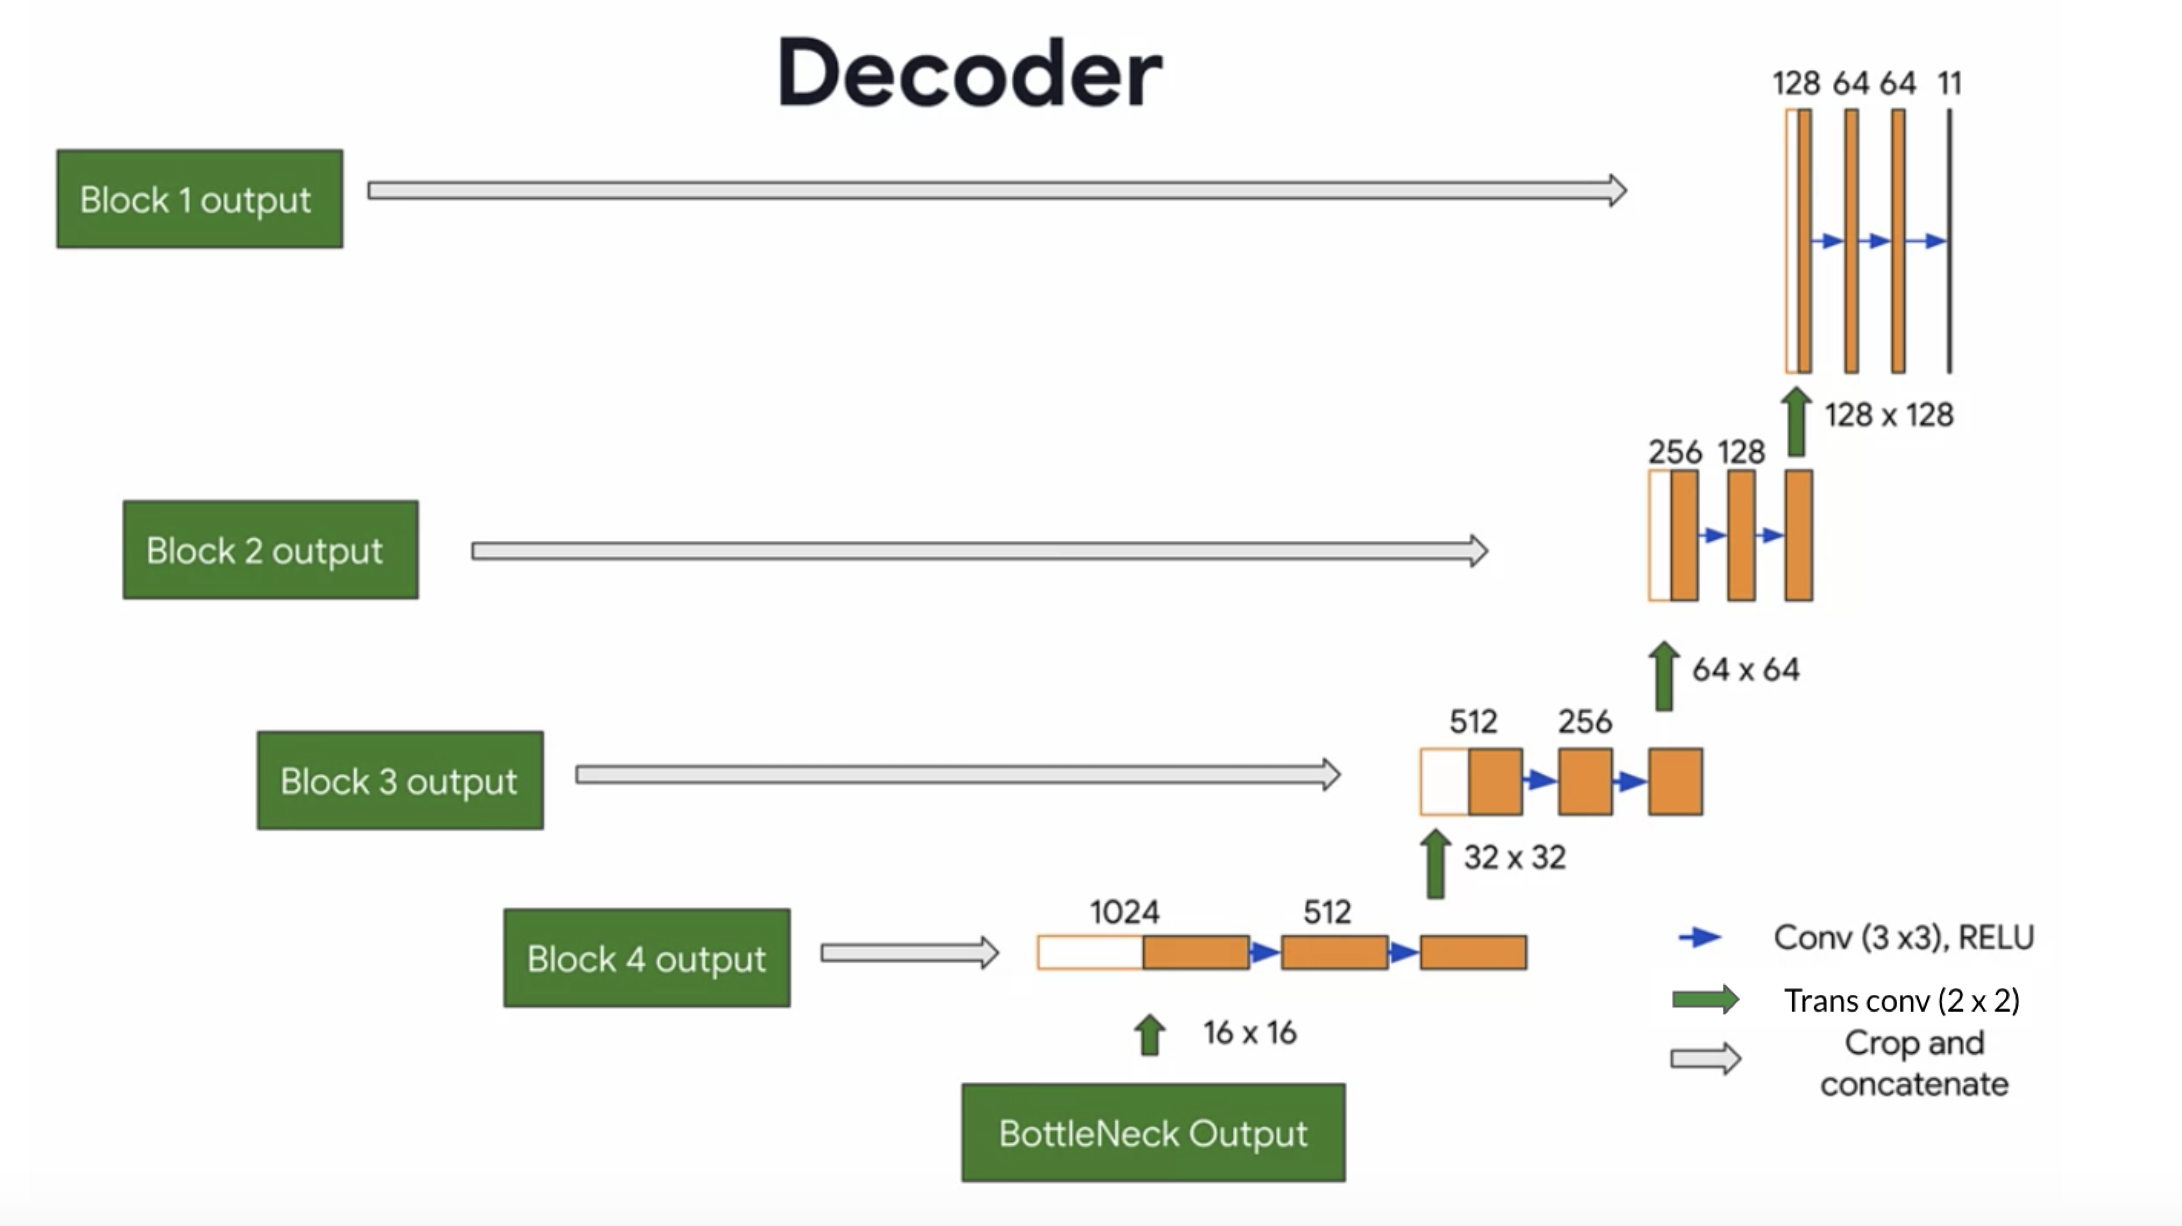<br>
The U-Net Decoder up close <br>

There are two new components in the decoder: `up` and `cat`. These are the transpose convolution and the skip connections. In addition, there are two more convolutional layers set to the same parameters as in the encoder.

Here you'll encounter the `ConvTranspose2d` layer, which performs the inverse of the `Conv2d` layer.



In [12]:
class upsampling_block(nn.Module):
    def __init__(self, in_ch, skip_ch, n_filters=32):
        """
        Convolutional upsampling block

        Arguments:
            in_ch -- Number of channels of input tensor from previous layer
            skip_ch -- Number of channels of input tensor from previous skip layer
            n_filters -- Number of filters for the convolutional layers
        """
        super().__init__()
        ######################################################
        ###################### TO DO #########################
        ######################################################
        
        self.in_ch = in_ch
        self.n_filters = n_filters
        self.skip_ch = skip_ch
  
        self.transpose = nn.Sequential(
            nn.ConvTranspose2d(self.in_ch, self.n_filters, kernel_size=2, stride=2, padding=0),
            nn.BatchNorm2d(self.n_filters),
            nn.ReLU(inplace=True)
        )

        self.convolution = nn.Sequential(
            nn.Conv2d(self.skip_ch + self.n_filters, self.n_filters, kernel_size=3, padding=1, bias=True),
            nn.BatchNorm2d(self.n_filters),
            nn.ReLU(inplace=True),
            nn.Conv2d(self.n_filters, self.n_filters, kernel_size=3, padding=1, bias=True),
            nn.BatchNorm2d(self.n_filters),
            nn.ReLU(inplace=True)
        )
        ######################################################
        ######################################################
        ######################################################
    def forward(self, expansive_input, contractive_input):
        """
        Convolutional upsampling forward

        Arguments:
            expansive_input -- Data from bottleneck or previous upsampling_block
            contractive_input -- Data from corresponding layer in the encoder
        Returns:
            conv -- Tensor output
        """
        ######################################################
        ###################### TO DO #########################
        ######################################################
        expansive_input = self.transpose(expansive_input)
        conv = torch.cat((contractive_input, expansive_input), dim=1)
        conv = self.convolution(conv)
        ######################################################
        ######################################################
        ######################################################
        return conv


<a name='3-4'></a>
### 3.4 - Build the Model

This is where you'll put it all together, by chaining the encoder, bottleneck, and decoder! You'll need to specify the number of output channels, which for this particular set would be 23. **That's because there are 23 possible labels for each pixel in this self-driving car dataset.**

In [13]:
class UNet(nn.Module):
    def __init__(self, in_ch=3, n_filters=32, n_classes=23):
        """
        UNet

        Arguments:
            in_ch -- Number of channels of input tensor from previous layer
            n_filters -- Number of filters for the convolutional layers
            n_classes -- Number of diffrent segments
        """
        super().__init__()

        self.in_ch = in_ch
        self.n_filters = n_filters
        self.n_classes = n_classes
        # Down-sampling
        ######################################################
        ###################### TO DO #########################
        ######################################################
        self.L1_down = conv_block(self.in_ch, self.n_filters, 0)
        self.L2_down = conv_block(self.n_filters, self.n_filters * 2, 0)
        self.L3_down = conv_block(self.n_filters * 2, self.n_filters * 4, 0.3)
        self.L4_down = conv_block(self.n_filters * 4, self.n_filters * 8, 0.3)
        self.bottle_neck = conv_block(self.n_filters * 8, self.n_filters * 16, 0, False)
        ######################################################
        ######################################################
        ######################################################

        # Up-sampling and final layer
        ######################################################
        ###################### TO DO #########################
        ######################################################
        self.L4_up = upsampling_block(self.n_filters * 16, self.n_filters * 8, self.n_filters * 8)
        self.L3_up = upsampling_block(self.n_filters * 8, self.n_filters * 4, self.n_filters * 4)
        self.L2_up = upsampling_block(self.n_filters * 4, self.n_filters * 2, self.n_filters * 2)
        self.L1_up = upsampling_block(self.n_filters * 2, self.n_filters, self.n_filters)
        ######################################################
        ######################################################
        ######################################################
        self.final_conv = nn.Sequential(
            nn.Conv2d(self.n_filters, self.n_classes, kernel_size = 1, padding = 0, stride = 1)
        )

    def forward(self, x):
        """
        UNet forward

        Arguments:
            x -- Input data/batch

        Returns:
            out -- Tensor output (Segmented image)
        """
        ######################################################
        ###################### TO DO #########################
        ######################################################

        out_L1_down, skip_L1_down = self.L1_down.forward(x)
        out_L2_down, skip_L2_down = self.L2_down.forward(out_L1_down)
        out_L3_down, skip_L3_down = self.L3_down.forward(out_L2_down)
        out_L4_down, skip_L4_down = self.L4_down.forward(out_L3_down)


        out_bottle_neck, _ = self.bottle_neck(out_L4_down)


        out_L4_up = self.L4_up.forward(out_bottle_neck, skip_L4_down)
        out_L3_up = self.L3_up.forward(out_L4_up, skip_L3_down)
        out_L2_up = self.L2_up.forward(out_L3_up, skip_L2_down)
        out_L1_up = self.L1_up.forward(out_L2_up, skip_L1_down)

        out = self.final_conv(out_L1_up)
        ######################################################
        ######################################################
        ######################################################

        return out

### Check out the model summary

In [14]:
unet = UNet().to(device)
summary(unet, (3, 192, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 192, 256]             896
       BatchNorm2d-2         [-1, 32, 192, 256]              64
              ReLU-3         [-1, 32, 192, 256]               0
            Conv2d-4         [-1, 32, 192, 256]           9,248
       BatchNorm2d-5         [-1, 32, 192, 256]              64
              ReLU-6         [-1, 32, 192, 256]               0
           Dropout-7         [-1, 32, 192, 256]               0
         MaxPool2d-8          [-1, 32, 96, 128]               0
            Conv2d-9          [-1, 64, 96, 128]          18,496
      BatchNorm2d-10          [-1, 64, 96, 128]             128
             ReLU-11          [-1, 64, 96, 128]               0
           Conv2d-12          [-1, 64, 96, 128]          36,928
      BatchNorm2d-13          [-1, 64, 96, 128]             128
             ReLU-14          [-1, 64, 

<a name='3-6'></a>
### 3.6 - Dataset Loader For training and test

Below, define a function that allows you to display both an input image, and its ground truth: the true mask. The true mask is what your trained model output is aiming to get as close to as possible.

In [15]:
from sklearn.model_selection import train_test_split

dataset = Segmentation_Dataset(image_path, mask_path)

#TODO: an instance of your custom dataset

train_dataset, test_dataset = train_test_split(dataset, test_size = 0.2, random_state=42)
#TODO: split your data with random_state=42 and test_size=0.2


train_dataloader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)
#TODO: DataLoader for train_dataset with batch size=BATCH_SIZE
test_dataloader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = False)
#TODO: DataLoader for test_dataset with batch size=BATCH_SIZE

(-0.5, 255.5, 191.5, -0.5)

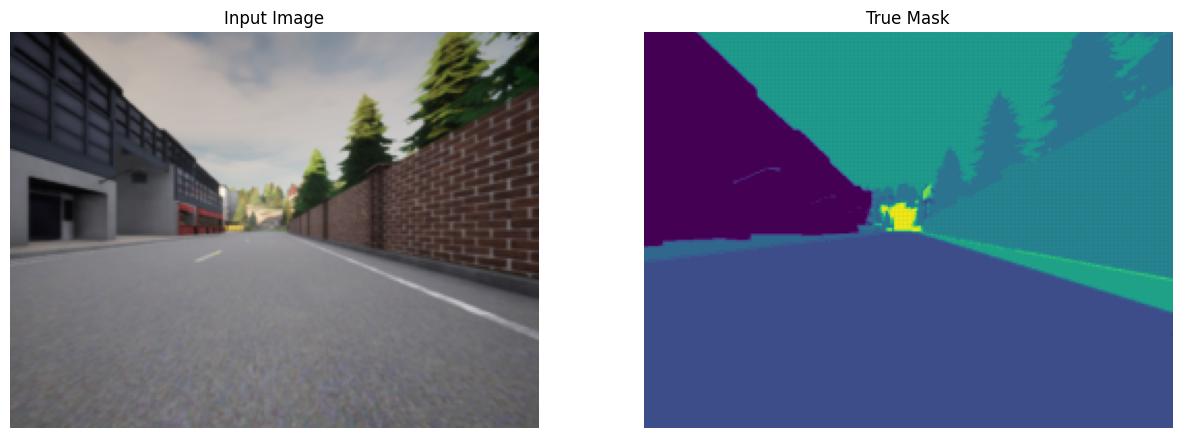

In [16]:
######################################################
###################### TO DO #########################
######################################################

fig, ax = plt.subplots(1, 2, figsize=(15, 15))

first_batch = next(iter(train_dataloader))

ax[0].imshow(np.transpose(first_batch[0][0].numpy(), (1, 2, 0)))
ax[0].set_title("Input Image")
ax[0].axis('off')

ax[1].imshow(np.transpose(first_batch[1][0].numpy(), (0,  1)))
ax[1].set_title("True Mask")
ax[1].axis('off')
# Show first image of first batch and its corresponding mask from the dataset


######################################################
######################################################
######################################################

<a name='3-7'></a>
### 3.7 - Loss Function

In semantic segmentation, you need as many masks as you have object classes. In the dataset you're using, each pixel in every mask has been assigned a single integer probability that it belongs to a certain class, from 0 to num_classes-1. The correct class is the layer with the higher probability.

We recommend using the cross entropy loss and the Adam optimizer.

In [17]:
criterion = nn.CrossEntropyLoss()

In [18]:
optimizer = Adam(unet.parameters(), lr = LR, betas = (B1, B2))

<a name='4'></a>
## 4 - Train the Model

Implement the `train` loop below to train the model.

In [19]:
start_time = time.time()

losses = []
for epoch in range(EPOCHS):
    epoch_losses = []
    for i, batch in enumerate(train_dataloader):
        ######################################################
        ###################### TO DO #########################
        ######################################################
        # Complete the train loop                            #
        # Hint: You might need to reshape MASK prior to      #
        #       calculating the loss using the code below:   #
        #       N, C, H, W = MASK.shape                      #
        #       MASK = MASK.reshape((N, H, W)).long()        #
        ######################################################
        ######################################################
        ######################################################
        x_train = batch[0].to(device)
        y_train = batch[1].to(device)
        y_pred = unet(x_train)

        loss = criterion(y_pred, y_train)

        optimizer.zero_grad()
        loss.backward()

        optimizer.step()

        epoch_losses.append(loss.item())
        print(f"EPOCH#{epoch},\t Batch#{i},\t Loss:{loss.item()}")
    losses.append(np.mean(epoch_losses))
    
end_time = time.time()
print(f"Execution time: {end_time - start_time} seconds")

EPOCH#0,	 Batch#0,	 Loss:3.136408567428589
EPOCH#0,	 Batch#1,	 Loss:3.05025315284729
EPOCH#0,	 Batch#2,	 Loss:3.009838342666626
EPOCH#0,	 Batch#3,	 Loss:2.9237592220306396
EPOCH#0,	 Batch#4,	 Loss:2.8498947620391846
EPOCH#0,	 Batch#5,	 Loss:2.803446054458618
EPOCH#0,	 Batch#6,	 Loss:2.7398269176483154
EPOCH#0,	 Batch#7,	 Loss:2.6815414428710938
EPOCH#0,	 Batch#8,	 Loss:2.6417484283447266
EPOCH#0,	 Batch#9,	 Loss:2.5928568840026855
EPOCH#0,	 Batch#10,	 Loss:2.560443162918091
EPOCH#0,	 Batch#11,	 Loss:2.556743860244751
EPOCH#0,	 Batch#12,	 Loss:2.469470977783203
EPOCH#0,	 Batch#13,	 Loss:2.4677937030792236
EPOCH#0,	 Batch#14,	 Loss:2.4572534561157227
EPOCH#0,	 Batch#15,	 Loss:2.3997962474823
EPOCH#0,	 Batch#16,	 Loss:2.3536646366119385
EPOCH#0,	 Batch#17,	 Loss:2.3439409732818604
EPOCH#0,	 Batch#18,	 Loss:2.3360748291015625
EPOCH#0,	 Batch#19,	 Loss:2.299116611480713
EPOCH#0,	 Batch#20,	 Loss:2.2690532207489014
EPOCH#0,	 Batch#21,	 Loss:2.2417118549346924
EPOCH#0,	 Batch#22,	 Loss:2.2543

<a name='4-1'></a>
### 4.1 - Create Predicted Masks

Now, define a function that uses `torch.argmax` in the axis of the number of classes to return the index with the largest value and merge the prediction into a single image:

_(The Predicted class of each pixel is the argmax of different probs assigned to that pixel)_

In [20]:
def create_mask(pred_mask):
    ######################################################
    ###################### TO DO #########################
    ######################################################
    pred_mask = torch.argmax(pred_mask, keepdim=True, axis=1)
    ######################################################
    ######################################################
    ######################################################

    return pred_mask

<a name='4-2'></a>
### 4.2 - Plot Loss Function

Plot the loss function value of your model in different iterations.

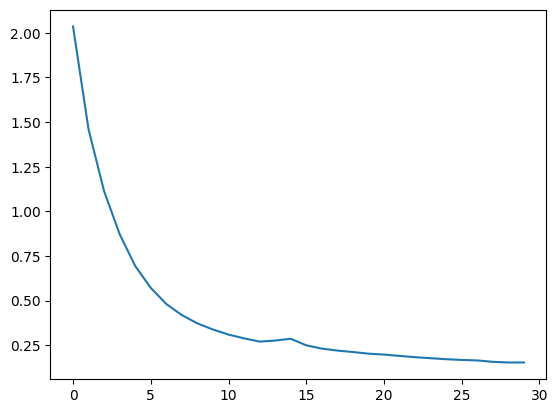

In [21]:
#TODO: plot the losses
plt.plot(range(EPOCHS), losses)

<a name='4-3'></a>
### 4.3 - mIoU

calculate mIoU for test dataset images and report average mIoU for all the images. (Remember that we have 23 classes in our dataset)

You can read about _mIoU_ metric and how it works [here](https://www.jeremyjordan.me/evaluating-image-segmentation-models/). Also, there are some other good resources on _Medium_, _Wikipedia_ and etc. on this subject. Just search for **What is mIoU in semantic segmentation**.

**Important Note**: You _can_ use some helper functions from _scikit-learn_ library to calculate mIoU, but you can not use functions (from any library) that calculate mIoU or IoU directly. You need to implement the calculation of mIoU by yourself.

In [22]:
import numpy as np
from sklearn.metrics import confusion_matrix

def calculate_miou(y_true, y_pred, num_classes):
    ######################################################
    ###################### TO DO #########################
    # Implement from scratch. Do not use ready-to-use IoU or mIoU functions from any library
    conf_mat = confusion_matrix(y_true.reshape(-1), y_pred.reshape(-1), labels=range(23))
    intersection = np.diag(conf_mat)
    union = torch.bincount(y_pred.reshape(-1), minlength=23).numpy() + torch.bincount(y_true.reshape(-1), minlength=23).numpy() - intersection
    
    iou = intersection / (union + 1e-80)
    return np.nanmean(iou)
    
    ######################################################
    ######################################################
    ######################################################

In [23]:
num_classes = 23
mious = []
for i, batch in enumerate(test_dataloader):
  with torch.no_grad():
    # TODO: pass images from test dataloader to the model
    # and get the predictions. Then calculate the mious
    # and finally, report the average miou for the test dataset
    y_preds = unet(batch[0].to(device)).cpu()
    preds = create_mask(y_preds)
    for i in range(len(batch[0])):
      mious.append(calculate_miou(batch[1][i], preds[i][0, :, :], num_classes))

print(f"average miou for test dataset: {sum(mious) / len(mious)}")


average miou for test dataset: 0.3504996628715027


<a name='4-3'></a>
### 4.5 - Show Predictions

Now, let's see your predictions (masks) vs ground truth masks to understand how well your model did.

In [24]:
def show_predictions(dataloader, device, num=1):
    """
    Displays the first image of each of the num batches
    """
    ######################################################
    ###################### TO DO #########################
    ######################################################
    fig, ax = plt.subplots(num, 3, figsize=(15, 5 * num))
    
    for idx, sample in enumerate(dataloader):
        if (idx == num):
            break
        y_pred = unet(sample[0].to(device))
        y_pred = create_mask(y_pred)
        y_pred = y_pred.cpu()
        
        if num == 1:
            ax[0].imshow(np.transpose(sample[0][0].numpy(), (1, 2, 0)))
            ax[0].set_title("Input Image")
            ax[0].axis('off')

            ax[1].imshow(np.transpose(sample[1][0].numpy(), (0,  1)))
            ax[1].set_title("True Mask")
            ax[1].axis('off')
                
            ax[2].imshow(np.transpose(y_pred[0][0].numpy(), (0,  1)))
            ax[2].set_title("Predicted Mask")
            ax[2].axis('off')
            
        else:
            ax[idx][0].imshow(np.transpose(sample[0][0].numpy(), (1, 2, 0)))
            ax[idx][0].set_title("Input Image")
            ax[idx][0].axis('off')

            ax[idx][1].imshow(np.transpose(sample[1][0].numpy(), (0,  1)))
            ax[idx][1].set_title("True Mask")
            ax[idx][1].axis('off')
                
            ax[idx][2].imshow(np.transpose(y_pred[0][0].numpy(), (0,  1)))
            ax[idx][2].set_title("Predicted Mask")
            ax[idx][2].axis('off')
        
    ######################################################
    ######################################################
    ######################################################

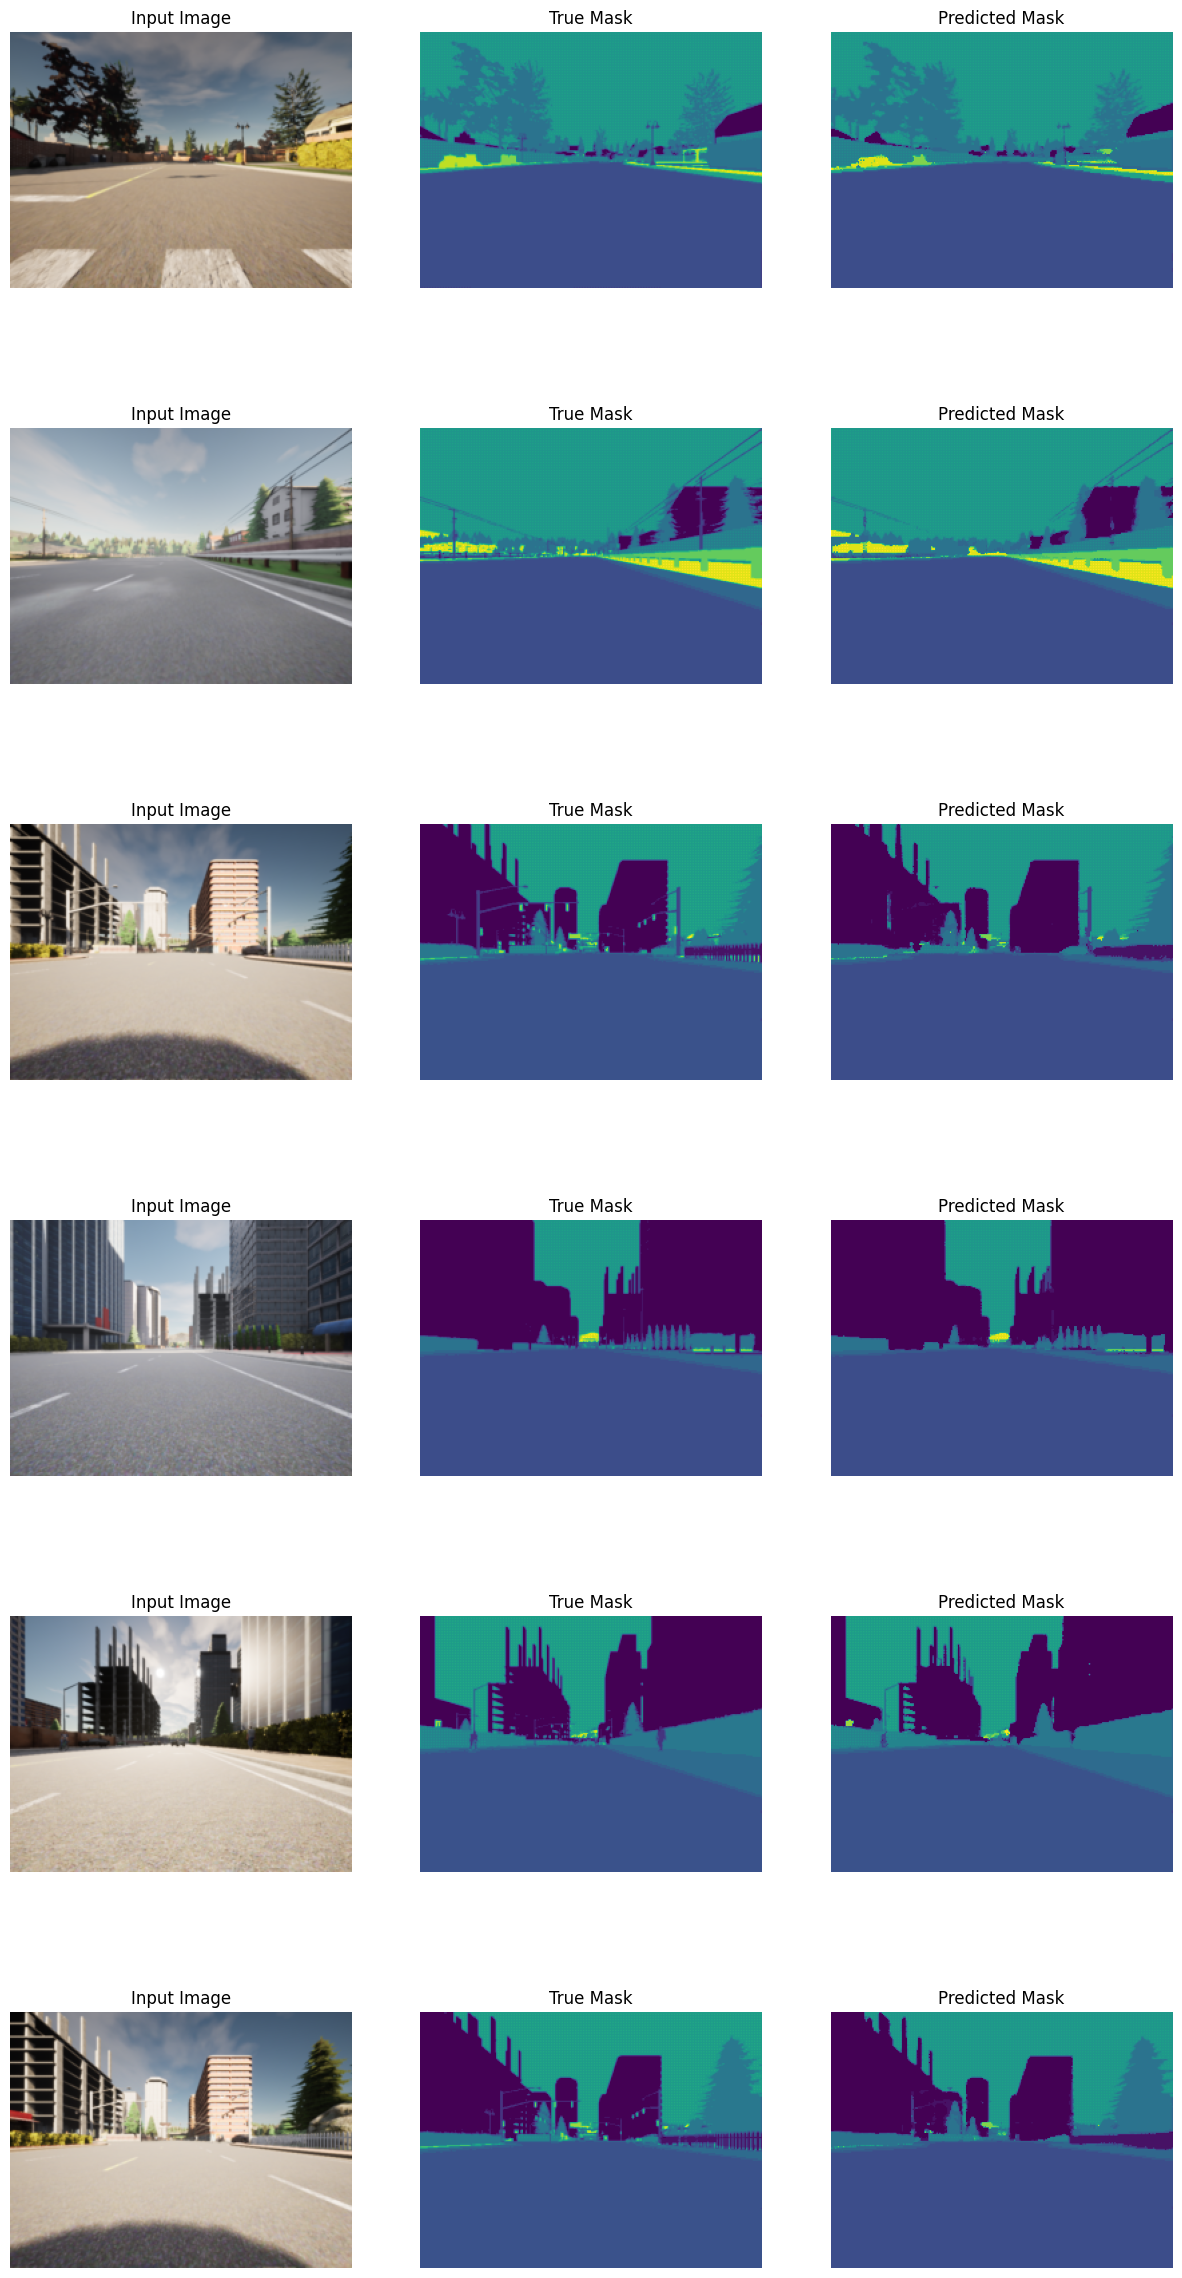

In [25]:
show_predictions(test_dataloader, device, 6)

## 5. Making the architecture better?!

Here, we want to try to make the UNet's model architecture, better. We try an approach named __Attention UNet__. This architecture tries to focus on the important parts of the image, and ignore the rest. Using this idea, we try to make the features (in `upsampling` steps) better, to finally reach a better __Decoder__ and thus, better predictions.

## 5.1 - Attention UNet

Here, is an overview of general architecture of Attention UNet:

<img src="root/Images/1.png" style="width:100%;height:auto;">

As you can see, the architecture is similar to the UNet, but with the addition of Attention Gates. These gates are used to focus on the important parts of the image, and ignore the rest. But, what are these attention gates, precisely?!

<img src="./Images/2.png" style="width:100%;height:auto;">

As you can see, the attention gate is a simple architecture, which uses the features from the encoder, and the features from the decoder, adds them and also uses residual connections to output $\hat{x_l}$. Please note that $W_x \in \mathbb{R}^{F_l \times F_{int}}$, $W_g \in \mathbb{R}^{F_g \times F_{int}}$ and $\Psi \in \mathbb{R}^{F_{int} \times 1}$ are linear transformations which are being computed using channel-wise $1 \times 1 \times 1$ convolutions for the input tensors. In other contexts, this is called _vector concatenation-based attention_, where the concatenated features $x^l$ and $g$ are linearly mapped into a $\mathbb{R}^F_{int}$ dimensional _intermediate_ space.

Let's design the `AttentionBlock` class, which will be used in the `AttentionUNet` model:

In [26]:
class AttentionBlock(nn.Module):
    def __init__(self, F_l, F_int, F_g):
        super(AttentionBlock, self).__init__()
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=2, stride=2, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )
        
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )
        
        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        
        self.relu = nn.ReLU(inplace=False)

    def forward(self, x, g):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)

        psi = nn.functional.interpolate(psi, size=x.size()[2:], mode='bilinear', align_corners=True)
        
        return x * psi


You can define new `conv_block` and `upsample_block` to meet the requirements of the `AttentionUNet` model. If your previous `conv_block` and `upsample_block` functions are compatible, you can just use them!

In [27]:
'''Based on the resources provided, there was no need to change the conv_block so we used the previous one'''

# class new_conv_block(nn.Module):
#     def __init__(self, in_ch, out_ch, dropout_prob=0):
#         super(new_conv_block, self).__init__()
#         ######################################################
#         ###################### TO DO #########################
#         ######################################################
#         pass
#         ######################################################
#         ######################################################
#         ######################################################

#     def forward(self, x):
#         #TODO: Implement the forward pass
#         return x

'Based on the resources provided, there was no need to change the conv_block so we used the previous one'

In [28]:
'''Based on the resources provided, there was no need to change the conv_block so we used the previous one'''

# class new_upsample_block(nn.Module):
#     def __init__(self, in_ch, out_ch):
#         super(new_upsample_block, self).__init__()
#         ######################################################
#         ###################### TO DO #########################
#         ######################################################
#         pass
#         ######################################################
#         ######################################################
#         ######################################################

'Based on the resources provided, there was no need to change the conv_block so we used the previous one'

In [29]:
class UNet_With_Attention(nn.Module):
    def __init__(self, in_ch=3, out_channel=23):
        """
        UNet with Attention

        Arguments:
            in_ch -- Number of channels of input tensor from previous layer
            out_channel -- Number of channels of output tensor
        """
        super().__init__()
        self.n_filters  = 32
        self.in_ch = in_ch
        self.out_channel = out_channel
        # Down-sampling
        ######################################################
        ###################### TO DO #########################
        ######################################################
        self.L1_down = conv_block(self.in_ch, self.n_filters)
        self.L2_down = conv_block(self.n_filters, self.n_filters * 2)
        self.L3_down = conv_block(self.n_filters * 2, self.n_filters * 4)
        self.L4_down = conv_block(self.n_filters * 4, self.n_filters * 8)
        self.bottle_neck = conv_block(self.n_filters * 8, self.n_filters * 16, 0, False)
        
        ######################################################
        ######################################################
        ######################################################

        # Up-sampling and final layer
        ######################################################
        ###################### TO DO #########################
        ######################################################
        self.L4_up = upsampling_block(self.n_filters * 16, self.n_filters * 8, self.n_filters * 8)
        self.L3_up = upsampling_block(self.n_filters * 8, self.n_filters * 4, self.n_filters * 4)
        self.L2_up = upsampling_block(self.n_filters * 4, self.n_filters * 2, self.n_filters * 2)
        self.L1_up = upsampling_block(self.n_filters * 2, self.n_filters, self.n_filters)
        
        
        self.Att4 = AttentionBlock(self.n_filters * 8, self.n_filters * 8, self.n_filters * 16)
        self.Att3 = AttentionBlock(self.n_filters * 4, self.n_filters * 4, self.n_filters * 8)
        self.Att2 = AttentionBlock(self.n_filters * 2, self.n_filters * 2, self.n_filters * 4)
        self.Att1 = AttentionBlock(self.n_filters , self.n_filters , self.n_filters * 2)
        ######################################################
        ######################################################
        ######################################################
        self.final_conv = nn.Sequential(
            nn.Conv2d(self.n_filters, self.out_channel, kernel_size = 1, padding = 0, stride = 1)
        )

    def forward(self, x):
        """
        UNet with Attention forward

        Arguments:
            x -- Input data/batch

        Returns:
            out -- Tensor output (Segmented image)
        """
        ######################################################
        ###################### TO DO #########################
        ######################################################
        out_L1_down, skip_L1_down = self.L1_down.forward(x)
        out_L2_down, skip_L2_down = self.L2_down.forward(out_L1_down)
        out_L3_down, skip_L3_down = self.L3_down.forward(out_L2_down)
        out_L4_down, skip_L4_down = self.L4_down.forward(out_L3_down)
        out_bottle_neck, _ = self.bottle_neck(out_L4_down)
     


        
        out_att_4 = self.Att4.forward(skip_L4_down, out_bottle_neck)
        out_L4_up = self.L4_up.forward(out_bottle_neck, out_att_4)
        
        out_att_3 = self.Att3.forward(skip_L3_down, out_L4_up)
        out_L3_up = self.L3_up.forward(out_L4_up, out_att_3)
        
     
        out_att_2 = self.Att2.forward(skip_L2_down, out_L3_up)
        out_L2_up = self.L2_up.forward(out_L3_up, out_att_2)
        
        out_att_1 = self.Att1.forward(skip_L1_down, out_L2_up)
        out_L1_up = self.L1_up.forward(out_L2_up, out_att_1)

        out = self.final_conv(out_L1_up)
        ######################################################
        ######################################################
        ######################################################

        return out

In [30]:
att_unet = UNet_With_Attention().to(device)
summary(att_unet, (3, 192, 256))
optimizer = Adam(att_unet.parameters(), lr = LR, betas = (B1, B2))
criterion = nn.CrossEntropyLoss()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 192, 256]             896
       BatchNorm2d-2         [-1, 32, 192, 256]              64
              ReLU-3         [-1, 32, 192, 256]               0
            Conv2d-4         [-1, 32, 192, 256]           9,248
       BatchNorm2d-5         [-1, 32, 192, 256]              64
              ReLU-6         [-1, 32, 192, 256]               0
           Dropout-7         [-1, 32, 192, 256]               0
         MaxPool2d-8          [-1, 32, 96, 128]               0
            Conv2d-9          [-1, 64, 96, 128]          18,496
      BatchNorm2d-10          [-1, 64, 96, 128]             128
             ReLU-11          [-1, 64, 96, 128]               0
           Conv2d-12          [-1, 64, 96, 128]          36,928
      BatchNorm2d-13          [-1, 64, 96, 128]             128
             ReLU-14          [-1, 64, 

Now, let's implement the training loop for our `Unet with Attention` model. (If you implemented a `train` function for previous part, you can simply reuse it here! If not, you can simply re-implement the loop)

In [31]:
start_time = time.time()

losses = []
for epoch in range(EPOCHS):
    epoch_losses = []
    for i, batch in enumerate(train_dataloader):

        ######################################################
        ###################### TO DO #########################
        ######################################################
        # Complete the train loop                            #
        # Hint: You might need to reshape MASK prior to      #
        #       calculating the loss using the code below:   #
        #       N, C, H, W = MASK.shape                      #
        #       MASK = MASK.reshape((N, H, W)).long()        #
        ######################################################
        ######################################################
        ######################################################
        
        x_train = batch[0].to(device)
        y_train = batch[1].to(device)
        y_pred = att_unet(x_train)

        loss = criterion(y_pred, y_train)

        optimizer.zero_grad()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(att_unet.parameters(), max_grad_norm)
        optimizer.step()

        epoch_losses.append(loss.item())

        print(f"EPOCH#{epoch},\t Batch#{i},\t Loss:{loss.item()}")
    losses.append(np.mean(epoch_losses))
    
end_time = time.time()
print(f"Execution time: {end_time - start_time} seconds")

EPOCH#0,	 Batch#0,	 Loss:3.200871706008911
EPOCH#0,	 Batch#1,	 Loss:3.127256155014038
EPOCH#0,	 Batch#2,	 Loss:3.0384883880615234
EPOCH#0,	 Batch#3,	 Loss:2.9500701427459717
EPOCH#0,	 Batch#4,	 Loss:2.9141845703125
EPOCH#0,	 Batch#5,	 Loss:2.86936092376709
EPOCH#0,	 Batch#6,	 Loss:2.7474052906036377
EPOCH#0,	 Batch#7,	 Loss:2.674044370651245
EPOCH#0,	 Batch#8,	 Loss:2.6261465549468994
EPOCH#0,	 Batch#9,	 Loss:2.568763017654419
EPOCH#0,	 Batch#10,	 Loss:2.524305820465088
EPOCH#0,	 Batch#11,	 Loss:2.467040777206421
EPOCH#0,	 Batch#12,	 Loss:2.4053544998168945
EPOCH#0,	 Batch#13,	 Loss:2.3751094341278076
EPOCH#0,	 Batch#14,	 Loss:2.384416341781616
EPOCH#0,	 Batch#15,	 Loss:2.321211099624634
EPOCH#0,	 Batch#16,	 Loss:2.2972302436828613
EPOCH#0,	 Batch#17,	 Loss:2.247494697570801
EPOCH#0,	 Batch#18,	 Loss:2.2494020462036133
EPOCH#0,	 Batch#19,	 Loss:2.1861677169799805
EPOCH#0,	 Batch#20,	 Loss:2.1789729595184326
EPOCH#0,	 Batch#21,	 Loss:2.1692516803741455
EPOCH#0,	 Batch#22,	 Loss:2.186150

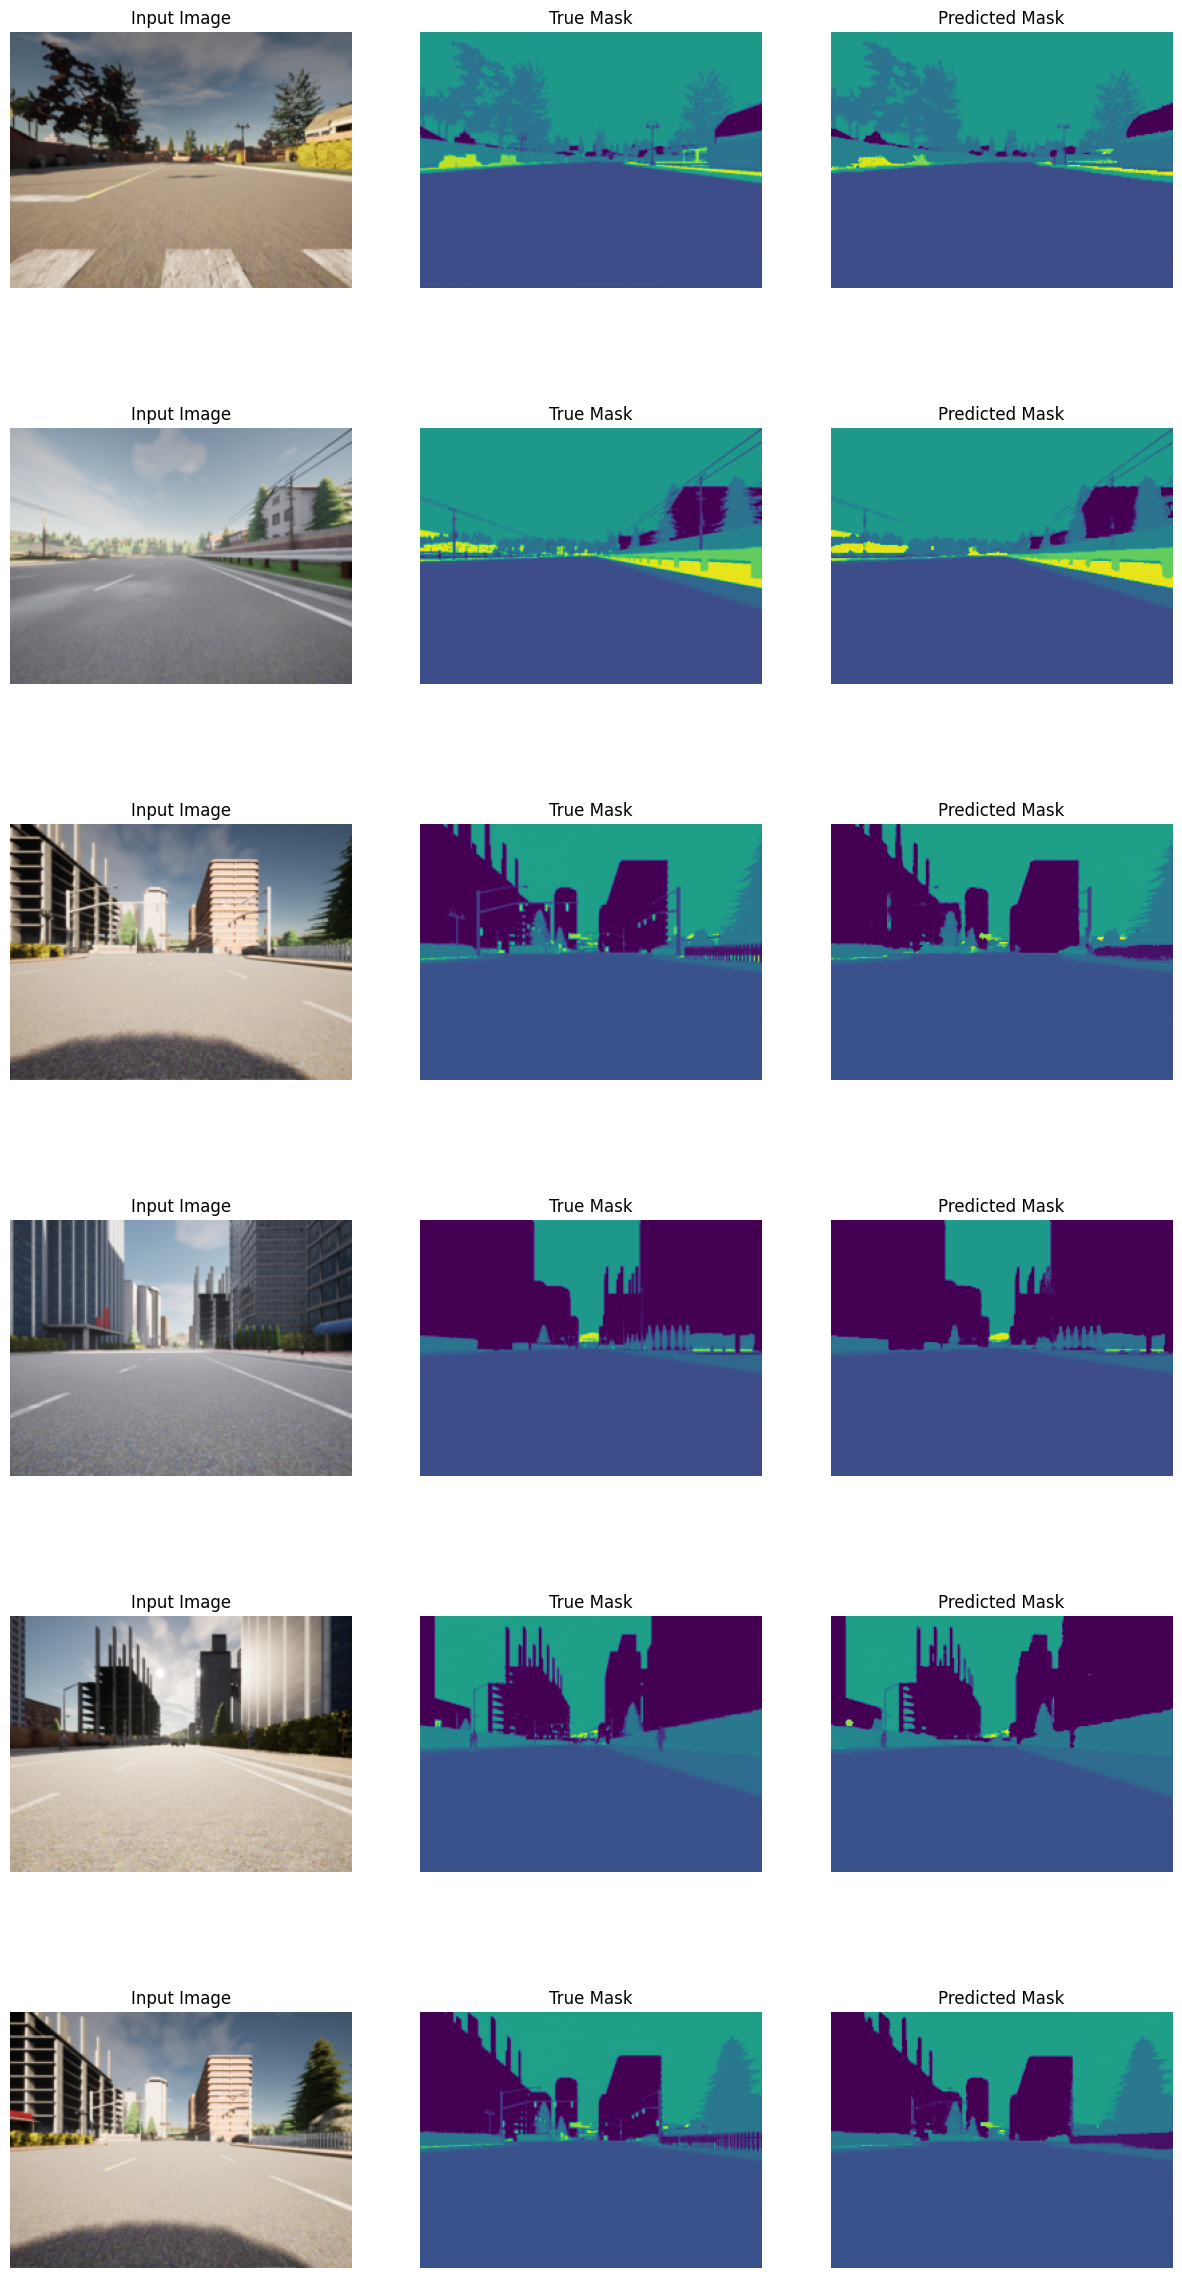

In [32]:
show_predictions(test_dataloader, device, 6)

Now, let's plot the `losses` vs `epochs` for the `AttentionUNet` model.

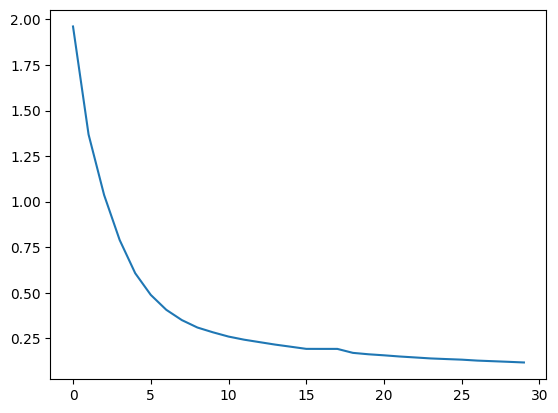

In [33]:
#TODO: plot the losses
plt.plot(range(EPOCHS), losses)

<a name='5-2'></a>
### 5.2 - mIoU

calculate mIoU for test dataset images with new model using the defined function above and report average mIoU for all the images.

In [34]:
num_classes = 23
mious = []
for i, batch in enumerate(test_dataloader):
  with torch.no_grad():
    # TODO: pass images from test dataloader to the model
    # and get the predictions. Then calculate the mious
    # and finally, report the average miou for the test dataset
    y_preds = att_unet(batch[0].to(device)).cpu()
    preds = create_mask(y_preds)
    for i in range(len(batch[0])):
      mious.append(calculate_miou(batch[1][i], preds[i][0, :, :], num_classes))

print(f"average miou for test dataset: {sum(mious) / len(mious)}")

average miou for test dataset: 0.4142048422349842


### 5.3
Compare the results between `Unet` and `AttentionUNet` models. Do your comparison in terms of `mIoU` and `loss` values, and also the `training time`. Which one is better in each of these metrics? Explain your answer based on the outputs and plots and loss values and mIoU values.

**Answer**:

AttentionUNet has a lower loss than UNet. This can be explained intutively like this: In the normal UNet, the skip layer provides us with the information of the exact location and whereabouts of an object, including that information in a single pixel, but the information coming from lower levels where we had to upsample gave us information about different areas of the image. By trying to convolve these two layers through a gate which was called the attention gate, we tried to put more focus on pixels that are more important and give us more information. This gives more weight to the pixels with more information and less weight to the ones that are not necessary and can even result in wrong predictions. This results in a better prediction, with less loss, and helps us converge to the right prediction more quickly. 

AttentionUNet also has a higher mIoU than the normal UNet. Referring back to the paragraph written before, we can see that if we lower our loss during training, we can get a better prediction result. Because of this, our mIoU which is the mean of Intersection of Union lowers which indicates that we have segmentated our image better and more clear way. 

On the other hand, we are expecting the execution time of our AttentionUnet to be higher (when the hyperparameters are the same) since we are adding more computations to our network. As the results show this is in fact true and it takes more time to run our data and train it in AttentionUNet, as if we wanted to run it on the normal UNet, but the difference is forgivable since we are getting a better result prediction wise. 

The result of both the loss and the mIoU for both models are included above. Another thing that was a great factor when training our models, no matter which, was the presence of nn.BatchNorm2d which greatly improved the results. Also finding the hyperparameteres was another challenge and finally got us to the point where we had to decrease our batch size in order to get a better result while also avoiding overfitting. 